In [89]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import pandas as pd
import array
from scipy.interpolate import griddata
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.optimize import root
import seaborn as sns

# Geospatial data manipulation and raster operations
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

from shapely.geometry import Point

# Electromagnetic induction data inversion package
from emagpy import Problem

from PM import *
%matplotlib inline

In [90]:
# 0.3: Get dataset location
# -------------------------
# store dataset URL's as string variables
FDEM_surveydata = 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/EM case survey/Code_EM_survey_case/survey_Lam72.csv'
FDEM_transect = 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/EM case survey/Code_EM_survey_case/ERT_PH_set.csv'
samples = 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/EM case survey/Code_EM_survey_case/samples_combined.csv'
#FDEM_surveydata = 'C:/Users/mendo/OneDrive - UGent/Documentos/PhD/EM case survey/Data/Proefhoeve/survey_042022/survey_Lam72.csv'
#FDEM_transect = 'C:/Users/mendo/OneDrive - UGent/Documentos/PhD/EM case survey/Code_EM_survey_case/ERT_PH_set.csv'
#samples = 'C:/Users/mendo/OneDrive - UGent/Documentos/PhD/EM case survey/Data/Proefhoeve/samples_combined.csv'

# URL for grid masking file
blank_json = 'https://users.ugent.be/~pjdsmedt/ESS2023/blank.json'

# Create dataframes from datasets
'''
Import datasets as dataframes
-----------------------------
    - df = dataframe with the full FDEM dataset
    - dt = dataframe with the FDEM transect
    - ds = datasframe with the sample data (including analytical data)
    - blank = geojson (polygon) outlining survey extent
'''
df = pd.read_csv(FDEM_surveydata, sep=',', header=0)
dt = pd.read_csv(FDEM_transect, sep=',', header=0, encoding='cp1252')
ds = pd.read_csv(samples, sep=',', header=0, encoding='cp1252')
blank_in = gpd.read_file(blank_json)
blank = blank_in.to_crs('EPSG:31370')
ds.columns

Index(['Unnamed: 0', 'x', 'y', 'z', 't', 'HCP0.5', 'PRP0.6', 'HCP1.0',
       'PRP1.1', 'HCP2.0', 'PRP2.1', 'HCP0.5_inph', 'PRP0.6_inph',
       'HCP1.0_inph', 'PRP1.1_inph', 'HCP2.0_inph', 'PRP2.1_inph', 'name',
       'depth', 'x_clhs', 'y_clhs', 'ph-eau', 'CEC', 'clay', 'silt', 'sand',
       'TOC', 'humus', 'bd', 'vwc', 'copeky', 'temp', 'rperm', 'iperm'],
      dtype='object')

In [91]:
offset = 4
water_perm = 80
ds['bulk_ec_hp'] = logsdon(50e6, ds.rperm, ds.iperm)

def objective_func_ec_dc(bulk_ec_dc, frequency_ec, bulk_ec):
    return (LongmireSmithEC(bulk_ec_dc, frequency_ec) - bulk_ec)**2
bulk_ec_dc_hp = []

for i in range(len(ds.bulk_ec_hp.values)):
    res = minimize(objective_func_ec_dc, 0.05, args=(50e6, ds.bulk_ec_hp[i]), bounds=[(0, 1)])
    bulk_ec_dc_hp.append(np.nan if np.isnan(res.fun) else round(res.x[0], 5) )

ds['bulk_ec_dc_hp'] = bulk_ec_dc_hp
ds['water_ec_hp'] = Hilhorst(ds.bulk_ec_hp, ds.rperm, water_perm, offset)


EC_columns = ['HCP0.5', 'PRP0.6', 'HCP1.0', 'PRP1.1', 'HCP2.0', 'PRP2.1'] 
for col in EC_columns:
    EC_DC = []
    for i in range(len(ds[col].values)):
        res = minimize(objective_func_ec_dc, 0.05, args=(9e3, ds[col][i]/1000), bounds=[(0, 1)])
        EC_DC.append(np.nan if np.isnan(res.fun) else round(res.x[0], 5) )

    ds[col+'_DC'] = EC_DC

In [92]:
results_r2 = pd.DataFrame(columns=['Aparent_HCP', 'Aparent_PRP', 'Inverted', 'Inverted_ERT'],
                  index=range(0, 2))

results_rmse = pd.DataFrame(columns=['Aparent_HCP', 'Aparent_PRP', 'Inverted', 'Inverted_ERT'],
                  index=range(0, 2))

100%|██████████| 30/30 [00:00<00:00, 15092.85it/s]


Error in // inversion: module 'numpy' has no attribute 'complex'.
`np.complex` was a deprecated alias for the builtin `complex`. To avoid this error in existing code, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
   Finished inversion


IndexError: list index out of range

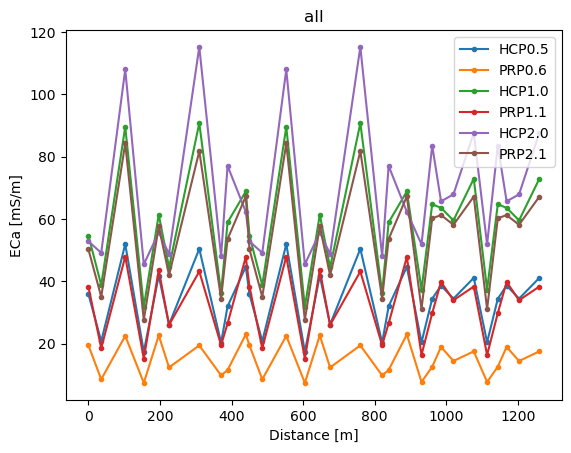

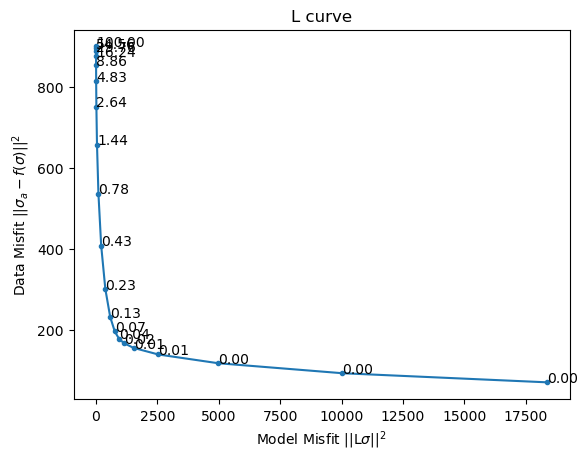

In [93]:
#depths_in = [0.1, 0.5, 0.8, 1.5]
depths_in = [0.4, 0.8]

# Set pdf name for exporting plot
pdf_name = 'Modelled_EC_profiles.pdf'

# ******************************************************************** #
# Create an inversion problem object to solve with EMagPy

sampling_path = samples
sample_transect = Problem()
sample_transect.createSurvey(sampling_path, freq=9000,hx=0.165,unit='ECa')
sample_transect.setInit(depths0=depths_in)
sample_transect.show()
sample_transect.lcurve()

# Run the inversion
sample_transect.invert(forwardModel='FSeq', alpha=0.03, njobs=-1) # FSIQ, alpha  check forwardModel='FSeq',
print('   Finished inversion')

# ----------------------------------------------------------------------
# Plotting and exporting the EC profiles figure as a pdf
# ----------------------------------------------------------------------

# Putting the results in a dataframe, and concatenate with analytical data.
depth_values = sample_transect.depths[0][0]
layer_cols = ['EC_{:.2f}'.format(d) for d in depth_values] + ['EC_end']
data = np.c_[sample_transect.surveys[0].df[['x', 'y']].values, 
             sample_transect.models[0]]

ds_inv = pd.DataFrame(data, columns=['x', 'y'] + layer_cols)
selected_columns_ds = pd.concat([ds.iloc[:, 3:11], ds.iloc[:, 17:]], axis=1)

ds_all = pd.concat([ds_inv, selected_columns_ds], axis=1)
#ds_all = ds_all.dropna()

unique_sample_ids = ds_all['name'].unique()

# Calculate number of rows and columns for the subplot
subplot_rows = 3
subplot_cols = 5

# Get axis limits
global_x_min = ds_all[layer_cols].min().min()
global_x_max = ds_all[layer_cols].max().max()

csv_filename = 'inverted_samples_PH.csv'
ds_all.to_csv(csv_filename)

In [ ]:
bulk_ec_dc_010 = []
for i in range(len(ds_all.bulk_ec_hp.values)):
    res = minimize(objective_func_ec_dc, 0.05, args=(9e3, ds_all['EC_0.40'][i]/1000), bounds=[(0, 1)])
    bulk_ec_dc_010.append(np.nan if np.isnan(res.fun) else round(res.x[0], 5) )

ds_all['bulk_ec_dc_010'] = bulk_ec_dc_010
ds_all_10cm = ds_all.loc[ds_all['depth']==10].reset_index(drop=True)

bulk_ec_dc_050 = []
for i in range(len(ds_all.bulk_ec_hp.values)):
    res = minimize(objective_func_ec_dc, 0.05, args=(9e3, ds_all['EC_0.80'][i]/1000), bounds=[(0, 1)])
    bulk_ec_dc_050.append(np.nan if np.isnan(res.fun) else round(res.x[0], 5) )

ds_all['bulk_ec_dc_050'] = bulk_ec_dc_050
ds_all_50cm = ds_all.loc[ds_all['depth']==50].reset_index(drop=True)

ds_all['bulk_ec_dc_inv'] = [ds_all.bulk_ec_dc_010[i] if ds_all.depth[i] == 10 else ds_all.bulk_ec_dc_050[i] for i in range(len(ds_all.vwc))]

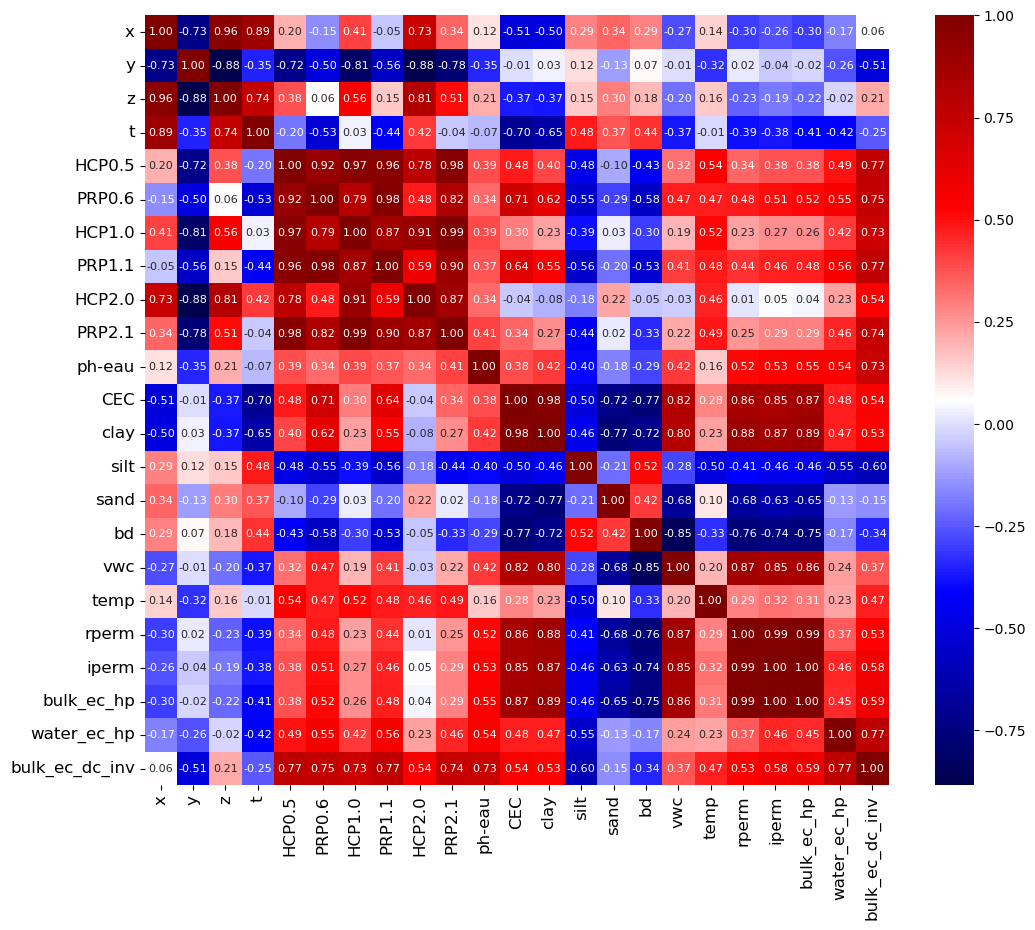

In [ ]:
ds_f = ds_all[['x', 'y', 'z', 't', 'HCP0.5', 'PRP0.6', 'HCP1.0',
       'PRP1.1', 'HCP2.0', 'PRP2.1', 'ph-eau', 'CEC', 'clay', 'silt', 'sand',
        'bd', 'vwc', 'temp', 'rperm', 'iperm', 'bulk_ec_hp', 'water_ec_hp', 'bulk_ec_dc_inv']]

# Setting the figure size
plt.figure(figsize=(12, 10))

# Plotting correlation heatmap with annotations
dataplot = sns.heatmap(ds_f.corr(), cmap="seismic", annot=True, fmt=".2f", annot_kws={"size": 8})

dataplot.tick_params(axis='both', which='major', labelsize=12)

# Rotating y-axis labels for better visualization
dataplot.set_yticklabels(dataplot.get_yticklabels(), rotation=0)

# Setting the label size for x and y axes
dataplot.set_xlabel(dataplot.get_xlabel(), fontsize=14)
dataplot.set_ylabel(dataplot.get_ylabel(), fontsize=14)

plt.show()

## Deterministic

In [ ]:
# Defining minimization function to obtain water using Fu
def objective_func_wat(x, clay, bulk_density, particle_density, water_ec, solid_ec, dry_ec, sat_ec, EC):
    return (Fu(x, clay, bulk_density, particle_density, water_ec, solid_ec, dry_ec, sat_ec) - EC)**2

def calculate_water(ds, col):
    wat = []
    for dc in ds[col]:
        res = minimize(objective_func_wat, 0.15, args=(ds.clay.mean(), ds.bd.mean(), 2.65, ds.water_ec_hp.mean(), 
                                                       0, np.nan, np.nan, dc), bounds=[(0, .65)])
        wat.append(np.nan if np.isnan(res.fun) else round(res.x[0], 3))
    
    r2_val = round(r2_score(ds.vwc.values, wat), 2)
    rmse_val = round(rmse(ds.vwc.values, wat), 2)
    return wat, r2_val, rmse_val

def plot_results(df, actual, predicted, r2_val, rmse_val, scale, title):
    
    fig, axes = plt.subplots(figsize=[7, 6])
    ss = 200
    
    # Create a colormap
    cmap = plt.cm.Reds

    # Loop through each point and plot with appropriate marker
    for i, (x, y, s) in enumerate(zip(actual, predicted, scale)):
        if ~(np.isnan(x) or np.isnan(y) or np.isnan(s)):
            if df['depth'].iloc[i] == 50:
                marker_style = 'D'
            else:
                marker_style = 'o'
            axes.scatter(x, y, s=ss, alpha=0.8, c=[s], cmap=cmap, vmin=0, vmax=80, marker=marker_style)

    # Create a dummy scatter plot to use its colormap
    dummy_scatter = plt.scatter([], [], c=[], cmap=cmap, vmin=0, vmax=80)
    cbar = plt.colorbar(dummy_scatter, ax=axes)

    axes.plot([0, 0.6], [0, 0.6], color='black', label=f'R2 = {r2_val}; RMSE = {rmse_val}')
    axes.set_xlabel("Observed wat")
    axes.set_ylabel("Predicted wat")
    axes.set_title(title)
    axes.legend()
    axes.grid(True)
    axes.set_xlim([0, 0.6])
    axes.set_ylim([0, 0.6])
    plt.show()

col HCP0.5_DC wat [0.281, 0.182, 0.371, 0.157, 0.316, 0.219, 0.363, 0.178, 0.257, 0.332, 0.281, 0.182, 0.371, 0.157, 0.316, 0.219, 0.363, 0.178, 0.257, 0.332, 0.179, 0.272, 0.298, 0.273, 0.312, 0.179, 0.272, 0.298, 0.273, 0.312]


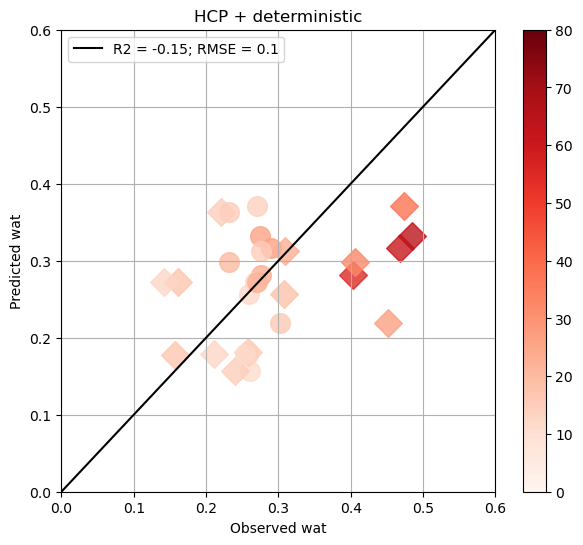

col PRP1.1_DC wat [0.295, 0.166, 0.35, 0.14, 0.327, 0.218, 0.324, 0.173, 0.222, 0.35, 0.295, 0.166, 0.35, 0.14, 0.327, 0.218, 0.324, 0.173, 0.222, 0.35, 0.15, 0.243, 0.304, 0.27, 0.296, 0.15, 0.243, 0.304, 0.27, 0.296]


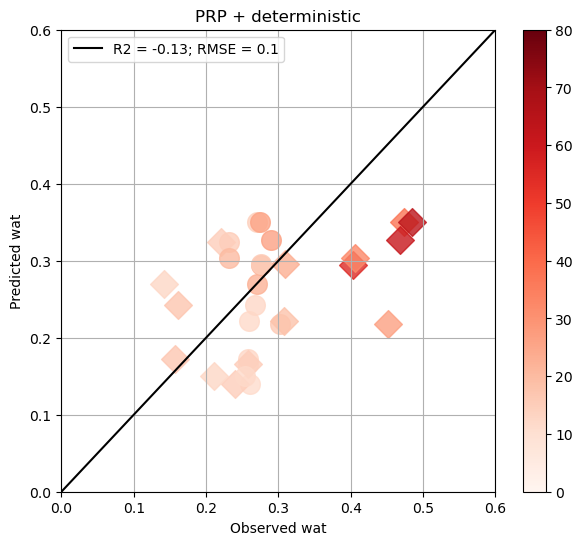

col bulk_ec_dc_inv wat [0.339, 0.161, 0.365, 0.122, 0.386, 0.239, 0.319, 0.17, 0.211, 0.407, 0.383, 0.286, 0.536, 0.247, 0.419, 0.324, 0.531, 0.281, 0.39, 0.455, 0.274, 0.42, 0.426, 0.405, 0.46, 0.131, 0.232, 0.341, 0.285, 0.304]


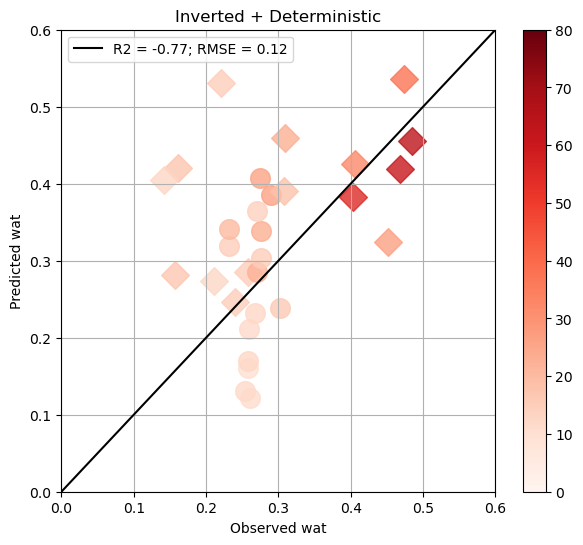

In [ ]:
cols_and_titles = [
    ('HCP0.5_DC', 'HCP + deterministic', 'Aparent_HCP'),
    ('PRP1.1_DC', 'PRP + deterministic', 'Aparent_PRP'), 
    ('bulk_ec_dc_inv', 'Inverted + Deterministic', 'Inverted')]

target = ds_all['vwc']
for col, title, result_col in cols_and_titles:
    if col:
        wat, r2_val, rmse_val = calculate_water(ds_all, col)
        results_r2[result_col][1] = r2_val
        results_rmse[result_col][1] = rmse_val
        print('col', col, 'wat', wat)
        plot_results(ds_all, target, wat, r2_val, rmse_val, ds_all.clay, title)

## Stochastic

In [ ]:

def stochastic_poly(df, feature_columns, target, max_degree=4):
    X = df[feature_columns]
    y_train_t = target[:20]
    y_test_t = target[20:]

    RMSE_test_pol, R2_test_pol, y_hat_test_t_ = [], [], []

    for n in range(max_degree):
        poly = PolynomialFeatures(degree=n)
        poly.fit(X)
        X_t = poly.transform(X)/1000
        X_train_t = X_t[:20]
        X_test_t = X_t[20:]

        LinReg = LinearRegression()
        LinReg.fit(X_train_t, y_train_t)

        R2_train_t = round(LinReg.score(X_train_t, y_train_t), 3)
        y_hat_test_t = LinReg.predict(X_test_t)

        y_hat_test_t_.append(y_hat_test_t)
        R2_test_t = round(r2_score(y_test_t, y_hat_test_t), 3)
        rmse_test_t = round(rmse(y_test_t, y_hat_test_t), 3)

        RMSE_test_pol.append(rmse_test_t)
        R2_test_pol.append(R2_test_t)

    index_best = R2_test_pol.index(max(R2_test_pol))
    return y_hat_test_t_[index_best], RMSE_test_pol[index_best], R2_test_pol[index_best]

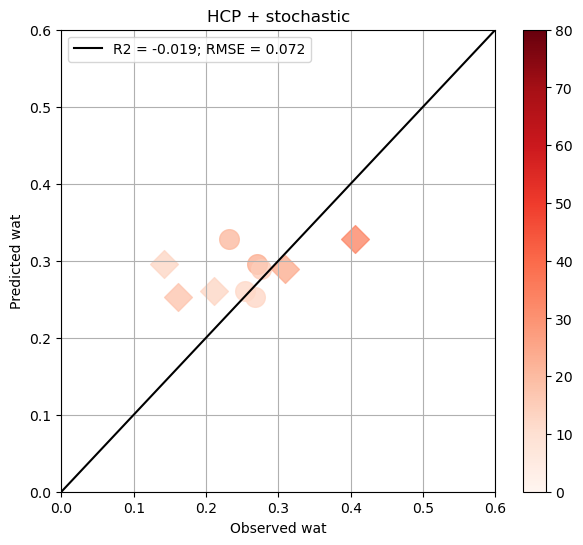

In [ ]:
# For HCP
target = ds['vwc']
y_hat_test_t_, RMSE_test_pol, R2_test_pol = stochastic_poly(ds, ['HCP0.5', 'HCP1.0'], target)

nan_array = np.full(20, np.nan)
pred = np.concatenate((nan_array, y_hat_test_t_))
ds_clay = np.concatenate((nan_array, ds.clay[20:]))
r2_apHCP_sc = R2_test_pol
rmse_apHCP_sc = RMSE_test_pol
results_r2.Aparent_HCP[0] = r2_apHCP_sc
results_rmse.Aparent_HCP[0] = rmse_apHCP_sc
plot_results(ds, target, pred, r2_apHCP_sc, rmse_apHCP_sc, ds_clay, 'HCP + stochastic')

y_hat_test_t_ [0.25312006 0.25707415 0.3263554  0.26633688 0.30402171 0.25312006
 0.25707415 0.3263554  0.26633688 0.30402171]


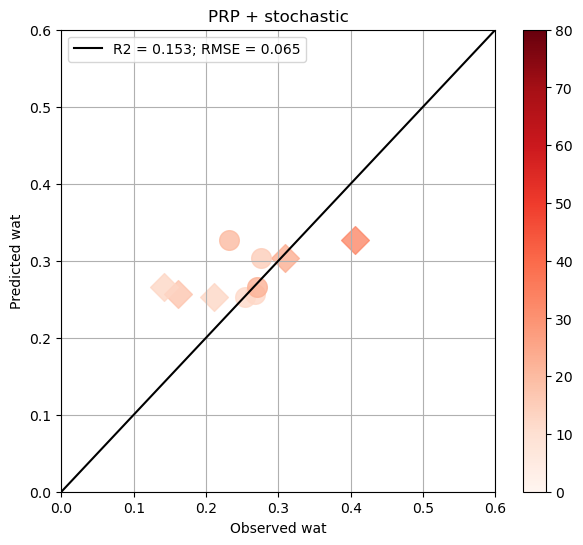

In [ ]:
# For PRP
target = ds['vwc']

y_hat_test_t_, RMSE_test_pol, R2_test_pol = stochastic_poly(ds, ['PRP0.6', 'PRP1.1'], target)
print('y_hat_test_t_', y_hat_test_t_)

pred = np.concatenate((nan_array, y_hat_test_t_))
ds_clay = np.concatenate((nan_array, ds.clay[20:]))
r2_apPRP_sc = R2_test_pol
rmse_apPRP_sc = RMSE_test_pol
results_r2.Aparent_PRP[0] = r2_apPRP_sc
results_rmse.Aparent_PRP[0] = rmse_apPRP_sc
plot_results(ds, target,pred, r2_apPRP_sc, rmse_apPRP_sc, ds_clay, 'PRP + stochastic')

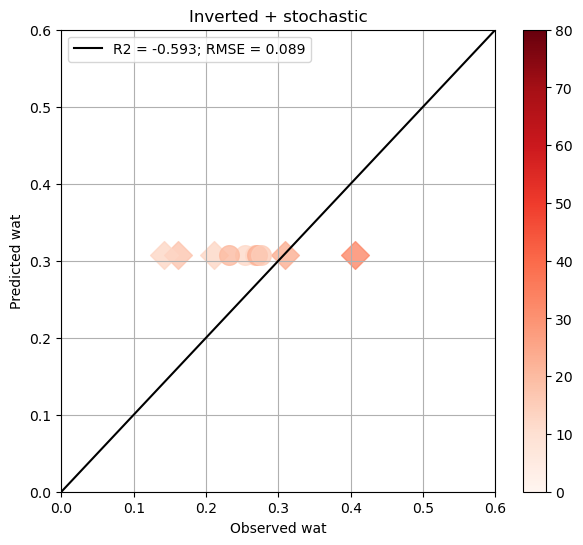

In [ ]:
# For Inverted
target = ds['vwc']

y_hat_test_t_, RMSE_test_pol, R2_test_pol = stochastic_poly(ds_all, ['bulk_ec_dc_inv'], target)
pred = np.concatenate((nan_array, y_hat_test_t_))
ds_clay = np.concatenate((nan_array, ds.clay[20:]))
r2_apINV_sc = R2_test_pol
rmse_apINV_sc = RMSE_test_pol
results_r2.Inverted[0] = r2_apINV_sc
results_rmse.Inverted[0] = rmse_apINV_sc
plot_results(ds, target, pred, r2_apINV_sc, rmse_apINV_sc, ds_clay, 'Inverted + stochastic')

In [ ]:
results_rmse

,Aparent_HCP,Aparent_PRP,Inverted,Inverted_ERT
0,0.072,0.065,0.089,NaN
1,0.1,0.1,0.12,NaN


In [ ]:
results_r2

,Aparent_HCP,Aparent_PRP,Inverted,Inverted_ERT
0,-0.019,0.153,-0.593,NaN
1,-0.15,-0.13,-0.77,NaN


In [ ]:
####################### 10 cm ##########################

wat = []
# Calculating water
for i in range(len(ds_all_10cm.bulk_ec_dc_010)):
    res = minimize(objective_func_wat, 0.15, args=(ds_all_10cm.clay.mean(), ds_all_10cm.bd.mean(), 2.65, 
                    ds_all_10cm.water_ec_hp.mean(), 0, np.nan, np.nan, ds_all_10cm.bulk_ec_dc_010[i]), bounds=[(0, .65)] )
    wat.append(np.nan if np.isnan(res.fun) else round(res.x[0], 3) )

r2_10cm = round(r2_score(ds_all_10cm.vwc.values, wat), 3)
rmse_10cm = round(rmse(ds_all_10cm.vwc.values, wat), 3)

####################### 50 cm ##########################

# Calculating water
for i in range(len(ds_all_50cm.bulk_ec_dc_050)):
    res = minimize(objective_func_wat, 0.15, args=(ds_all_50cm.clay.mean(), ds_all_50cm.bd.mean(), 2.65, 
                    ds_all_50cm.water_ec_hp.mean(), 0, np.nan, np.nan, ds_all_50cm.bulk_ec_dc_050[i]), bounds=[(0, .65)] )
    wat.append(np.nan if np.isnan(res.fun) else round(res.x[0], 3) )

r2_50cm = round(r2_score(ds_all_50cm.vwc.values, wat[15:]), 3)
rmse_50cm = round(rmse(ds_all_50cm.vwc.values, wat[15:]), 3)

r2_inv_dt = round(r2_score(ds_all.vwc.values, wat), 3)
rmse_inv_dt = round(rmse(ds_all.vwc.values, wat), 3)
print(r2_inv_dt, rmse_inv_dt)

-1.412 0.139
